In [3]:
# Viz
import hvplot.xarray
import numpy as np
import odc.stac
import pandas as pd
import planetary_computer
import pyproj
import pystac_client
import xarray as xr
from dask.distributed import Client
from pystac.extensions.eo import EOExtension as eo

In [5]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

bbox = [-118.89, 38.54, -118.57, 38.84]  # Region over a lake in Nevada, USA
datetime = "2017-06-01/2017-09-30"  # Summer months of 2017
collection = "landsat-c2-l2"
platform = "landsat-8"
cloudy_less_than = 1  # percent

search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}, "platform": {"in": [platform]}},
)
items = search.item_collection()
print(f"Returned {len(items)} Items:")
[[i, item.id] for i, item in enumerate(items)]

Returned 3 Items:


[[0, 'LC08_L2SP_042033_20170718_02_T1'],
 [1, 'LC08_L2SP_042033_20170702_02_T1'],
 [2, 'LC08_L2SP_042033_20170616_02_T1']]

In [6]:
item = items[1]  # select one of the results

In [8]:
# TODO: show the pre-rendered thumbnail
list(item.assets.keys())[:30]

['qa',
 'ang',
 'red',
 'blue',
 'drad',
 'emis',
 'emsd',
 'trad',
 'urad',
 'atran',
 'cdist',
 'green',
 'nir08',
 'lwir11',
 'swir16',
 'swir22',
 'coastal',
 'mtl.txt',
 'mtl.xml',
 'mtl.json',
 'qa_pixel',
 'qa_radsat',
 'qa_aerosol',
 'tilejson',
 'rendered_preview']

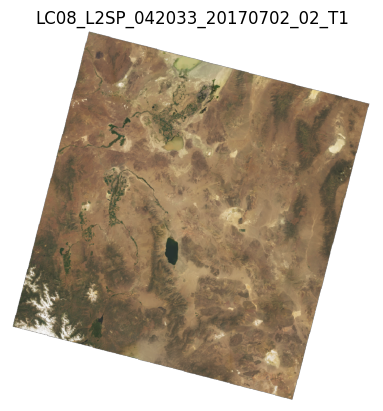

In [11]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import planetary_computer as pc
preview_url = pc.sign(item.assets["rendered_preview"].href)

img = Image.open(BytesIO(requests.get(preview_url).content))
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.title(item.id)
plt.show()

In [14]:
# Inspect band information
assets = []
for _, asset in item.assets.items():
    try:
        assets.append(asset.extra_fields["eo:bands"][0])
    except:
        pass

cols_ordered = [
    "common_name",
    "description",
    "name",
    "center_wavelength",
    "full_width_half_max",
]
bands = pd.DataFrame.from_dict(assets)[cols_ordered]
bands

,common_name,description,name,center_wavelength,full_width_half_max
0,red,Visible red,OLI_B4,0.65,0.04
1,blue,Visible blue,OLI_B2,0.48,0.06
2,green,Visible green,OLI_B3,0.56,0.06
3,nir08,Near infrared,OLI_B5,0.87,0.03
4,lwir11,Long-wave infrared,TIRS_B10,10.90,0.59
5,swir16,Short-wave infrared,OLI_B6,1.61,0.09
6,swir22,Short-wave infrared,OLI_B7,2.20,0.19
7,coastal,Coastal/Aerosol,OLI_B1,0.44,0.02


In [16]:
ds_2017 = odc.stac.stac_load(
    [item],
    bands=bands.common_name.values,
    bbox=bbox,
    chunks={},  # <-- use Dask
    resolution=100,
).isel(time=0)
ds_2017

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 339, x: 285)
Coordinates:
  * y            (y) float64 3kB 4.301e+06 4.301e+06 ... 4.267e+06 4.267e+06
  * x            (x) float64 2kB 3.353e+05 3.354e+05 ... 3.636e+05 3.637e+05
    spatial_ref  int32 4B 32611
    time         datetime64[ns] 8B 2017-07-02T18:33:06.200763
Data variables:
    red          (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    blue         (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    green        (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    nir08        (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    lwir11       (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    swir16       (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    swir22       (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>
    coastal      (y, x) uint16 193kB dask.array<chunksize=(339, 285), meta=np.ndarray>

The dataset has spatial dimensions of 339 × 285 pixels.
Each band is stored as a single Dask chunk whose chunk size equals the full spatial extent of the image.
Therefore, the chunk size is identical to the total array size, meaning that each band will be loaded and processed as one block rather than being tiled into smaller chunks.

In [18]:
epsg = item.properties["proj:code"]
ds_2017.attrs["crs"] = f"epsg:{epsg}"
epsg

'EPSG:32611'